In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import feature_scoring
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
from sklearn import tree
from pprint import pprint 
import graphviz
import sklearn
import dtreeviz

import os
import sys
sys.path.insert(0, '..')

from archspace import GatewayOffloading, ArchSpace
from archspace import show_pairplot, show_feature_scores, show_outcome_distributions, show_tradeoff_distribution
from archspace import show_quality_attribute_space2D, show_configuration_space2D

In [2]:
# Load the dataset for the pattern
my_space = GatewayOffloading()
my_space.create_model('gateway offloading')

experiments_df, outcomes_df = my_space.load_results('./multi_N25.csv', reverse=True)

print(len(my_space.get_configurations()), "configurations")

(286, 39)
filtered size: (78, 11)
3 configurations


In [3]:
experiments_df

,scenario,policy,N_A,N_B,Z_A,Z_B,S_gw,s_A_s1,s_B_s2,s_B_s3,model
0,4,no-offloading,0,25,100.0,100.0,1.000000e-15,20.0,12.0,15.0,gateway_offloading
1,28,no-offloading,1,24,100.0,100.0,1.000000e-15,20.0,12.0,15.0,gateway_offloading
2,153,no-offloading,2,23,100.0,100.0,1.000000e-15,20.0,12.0,15.0,gateway_offloading
3,26,no-offloading,3,22,100.0,100.0,1.000000e-15,20.0,12.0,15.0,gateway_offloading
4,53,no-offloading,4,21,100.0,100.0,1.000000e-15,20.0,12.0,15.0,gateway_offloading
...,...,...,...,...,...,...,...,...,...,...,...
73,224,long-services-offloaded,21,4,100.0,100.0,1.000000e+01,20.0,12.0,15.0,gateway_offloading
74,260,long-services-offloaded,22,3,100.0,100.0,1.000000e+01,20.0,12.0,15.0,gateway_offloading
75,279,long-services-offloaded,23,2,100.0,100.0,1.000000e+01,20.0,12.0,15.0,gateway_offloading
76,273,long-services-offloaded,24,1,100.0,100.0,1.000000e+01,20.0,12.0,15.0,gateway_offloading


In [4]:
experiments_df.describe()

,scenario,N_A,N_B,Z_A,Z_B,S_gw,s_A_s1,s_B_s2,s_B_s3
count,78.000000,78.000000,78.000000,78.0,78.0,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01
mean,143.051282,12.500000,12.500000,100.0,100.0,5.000000e+00,2.000000e+01,1.200000e+01,1.500000e+01
std,83.706025,7.548544,7.548544,0.0,0.0,4.108907e+00,7.151418e-15,2.919554e-15,8.449070e-15
min,4.000000,0.000000,0.000000,100.0,100.0,1.000000e-15,2.000000e+01,1.200000e+01,1.500000e+01
25%,70.250000,6.000000,6.000000,100.0,100.0,1.000000e-15,2.000000e+01,1.200000e+01,1.500000e+01
50%,143.500000,12.500000,12.500000,100.0,100.0,5.000000e+00,2.000000e+01,1.200000e+01,1.500000e+01
75%,214.750000,19.000000,19.000000,100.0,100.0,1.000000e+01,2.000000e+01,1.200000e+01,1.500000e+01
max,281.000000,25.000000,25.000000,100.0,100.0,1.000000e+01,2.000000e+01,1.200000e+01,1.500000e+01


In [5]:
# experiments_df.hist(column='S_gw', bins=15)
# experiments_df.hist(column=['r_A_s1', 'r_B_s2', 'r_B_s3'])
# experiments_df.hist(column=['N_A', 'N_B'])

In [6]:
experiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   scenario  78 non-null     int64  
 1   policy    78 non-null     object 
 2   N_A       78 non-null     int64  
 3   N_B       78 non-null     int64  
 4   Z_A       78 non-null     float64
 5   Z_B       78 non-null     float64
 6   S_gw      78 non-null     float64
 7   s_A_s1    78 non-null     float64
 8   s_B_s2    78 non-null     float64
 9   s_B_s3    78 non-null     float64
 10  model     78 non-null     object 
dtypes: float64(6), int64(3), object(2)
memory usage: 6.8+ KB


In [7]:
outcomes_df

,response_time,utilization
0,375.018656,1.029954e-20
1,334.006373,8.818039e-20
2,302.194299,6.634742e-20
3,278.952423,1.994418e-20
4,259.747814,7.656941e-20
...,...,...
73,250.986424,9.946960e-01
74,250.842555,9.920406e-01
75,256.493763,9.855351e-01
76,259.012525,9.577435e-01


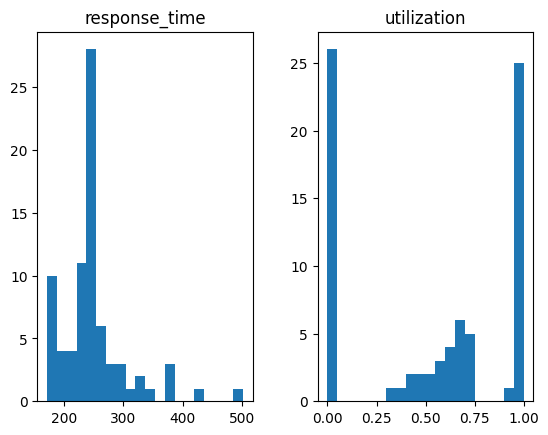

In [8]:
# Show distribution of the quality-attribute metrics
outcomes_df.hist(bins=20, grid=False)
plt.show()

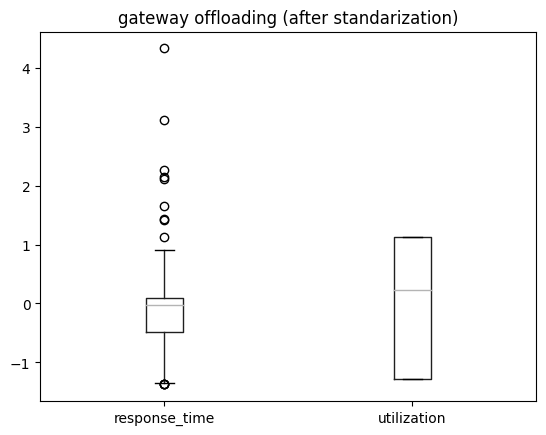

In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(outcomes_df)
scaled_df = pd.DataFrame(scaled_data, columns=outcomes_df.columns)
scaled_df.boxplot(grid=False)
plt.title('gateway offloading (after standarization)')
plt.show()

# It might need to filter outliers

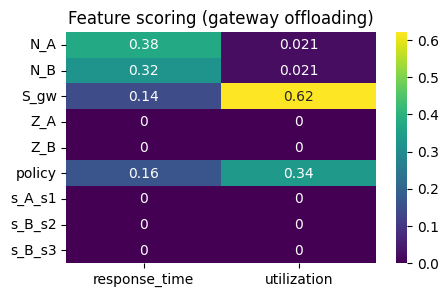

,response_time,utilization
0,,
N_A,0.375152,0.020506
N_B,0.321956,0.021385
S_gw,0.141961,0.621440
Z_A,0.000000,0.000000
Z_B,0.000000,0.000000
policy,0.160931,0.336669
s_A_s1,0.000000,0.000000
s_B_s2,0.000000,0.000000
s_B_s3,0.000000,0.000000


In [10]:
policy_size = (5,3)
filter_params = None # Screening most important parameters 
fs = show_feature_scores(my_space, title='Feature scoring (gateway offloading)', size=policy_size) #, filename=None)  
fs

In [11]:
my_policies = my_space.get_configurations()
my_policies

['long-services-offloaded', 'short-services-offloaded', 'no-offloading']

In [12]:
outcomes_df.describe()

,response_time,utilization
count,78.000000,7.800000e+01
mean,251.042635,5.309743e-01
std,58.126934,4.170128e-01
min,171.679852,0.000000e+00
25%,222.785205,7.575721e-20
50%,249.183684,6.285050e-01
75%,256.254154,9.968248e-01
max,501.360385,9.999953e-01


Absolute ranges: [(170.0, 505.0), (0.0, 1.0)]
response_time [169.9, 281.6333333333333, 393.3666666666667, 505.1]
utilization [-0.1, 0.30000000000000004, 0.7000000000000002, 1.1]


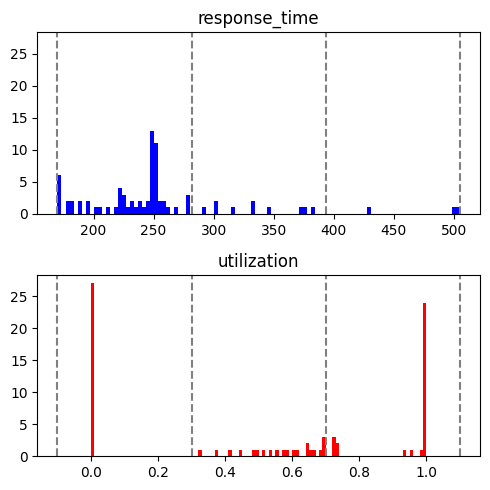

In [13]:
# Setting the ranges for the labels of quality attributes
MIN_RESPONSE_TIME, MAX_RESPONSE_TIME = (170.0, 505.0)
MIN_UTILIZATION, MAX_UTILIZATION = (0.0, 1.0)
MIN_MAX_RANGES = [(MIN_RESPONSE_TIME, MAX_RESPONSE_TIME), (MIN_UTILIZATION, MAX_UTILIZATION)]
print('Absolute ranges:', MIN_MAX_RANGES)

_ = show_outcome_distributions(my_space, mins_maxs=MIN_MAX_RANGES, size=(5,5))

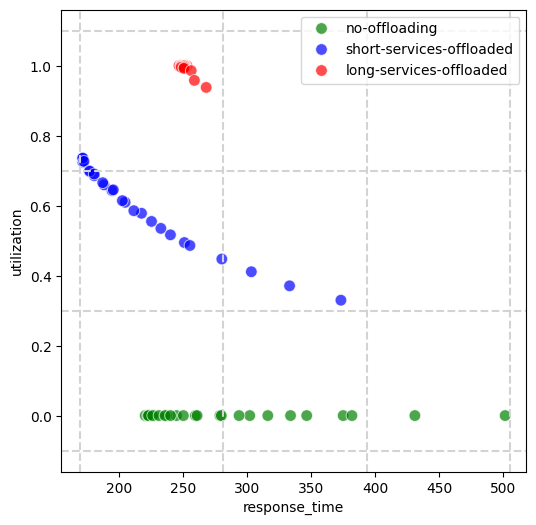

In [14]:
df = outcomes_df.copy()
df['decision'] = experiments_df['policy']
color_key = {'long-services-offloaded': 'red',
             'short-services-offloaded': 'blue',
             'no-offloading': 'green'}
show_quality_attribute_space2D(df, MIN_MAX_RANGES, alpha=0.7,color_key=color_key)

In [15]:
# Count feasible tradeoffs in the dataset
_ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)
print("Experiments:", experiments_df.shape)
my_space.available_tradeoffs_


Experiments: (78, 11)


Counter({'fast,high': 31,
         'fast,average': 18,
         'fast,low': 17,
         'average,low': 7,
         'average,average': 3,
         'slow,low': 2})

In [16]:
# Split dataset for ML analysis (train/test sets). Also outliers removal
X_train, X_test, y_train, y_test = my_space.split_dataset(test_size=0.4, remove_outliers=3)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(78, 13) 78
Removing outliers ... 3
Instances to remove (outliers): {24, 25}
Instances to remove (not enough tradeoffs): {24, 25}
{'fast,low', 'average,low', 'fast,average', 'average,average', 'fast,high'}
(76, 13) 76
(45, 13) (45, 2) (31, 13) (31, 2)


In [17]:
X_train[['response_time', 'utilization']].describe()

,response_time,utilization
count,45.000000,4.500000e+01
mean,242.903621,5.386295e-01
std,46.495536,4.066250e-01
min,171.878544,9.695430e-21
25%,222.638848,8.818039e-20
50%,249.381282,6.449009e-01
75%,255.535326,9.946960e-01
max,375.018656,9.999953e-01


In [18]:
X_test[['response_time', 'utilization']].describe()

,response_time,utilization
count,31.000000,3.100000e+01
mean,248.978352,5.541182e-01
std,47.221182,4.294195e-01
min,171.679852,0.000000e+00
25%,226.873507,7.091695e-20
50%,248.632163,6.430208e-01
75%,251.389221,9.982939e-01
max,381.879665,9.999425e-01


Absolute ranges: [(171, 385), (0.0, 1.0)]
response_time [170.9, 242.3, 313.70000000000005, 385.1]
utilization [-0.1, 0.30000000000000004, 0.7000000000000002, 1.1]


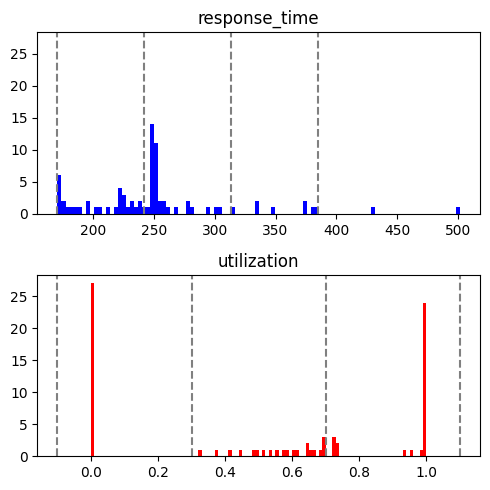

{'response_time': [170.9, 242.3, 313.70000000000005, 385.1],
 'utilization': [-0.1, 0.30000000000000004, 0.7000000000000002, 1.1]}

In [19]:
MIN_RESPONSE_TIME, MAX_RESPONSE_TIME = (171, 385) 
MIN_UTILIZATION, MAX_UTILIZATION = (0.0, 1.0) 
MIN_MAX_RANGES = [(MIN_RESPONSE_TIME, MAX_RESPONSE_TIME), (MIN_UTILIZATION, MAX_UTILIZATION)]
print('Absolute ranges:', MIN_MAX_RANGES)

show_outcome_distributions(my_space, mins_maxs=MIN_MAX_RANGES, size=(5,5))

In [20]:
df_concat = pd.concat([X_train, X_test], axis=0)
df_concat.reset_index(drop=True, inplace=True)
df_concat[['response_time', 'utilization']].describe()

,response_time,utilization
count,76.000000,7.600000e+01
mean,245.381472,5.449473e-01
std,46.575142,4.133049e-01
min,171.679852,0.000000e+00
25%,222.566122,8.010690e-20
50%,248.895057,6.439609e-01
75%,253.699932,9.977156e-01
max,381.879665,9.999953e-01


Experiments: (78, 11)
Counter({'average,high': 26, 'fast,average': 15, 'fast,low': 11, 'average,low': 8, 'slow,low': 5, 'fast,high': 5, 'average,average': 4, 'slow,average': 2})


<Figure size 7680x5760 with 0 Axes>

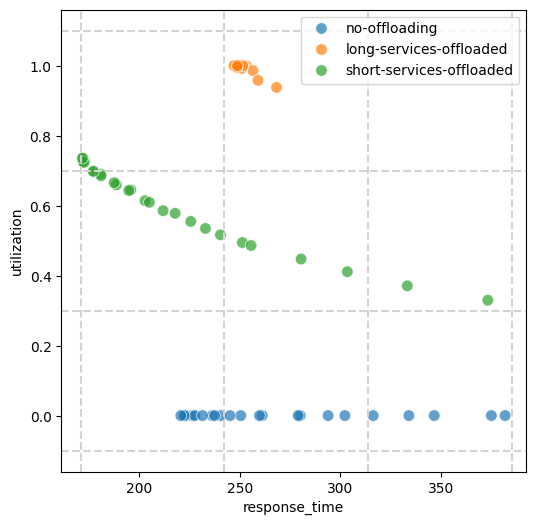

In [24]:
plt.gcf().set_dpi(1200)

# my_space.import_dataset(df_concat, df_concat[['response_time', 'utilization']])
 
_ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)
print("Experiments:", experiments_df.shape)
print(my_space.available_tradeoffs_)

df = df_concat[['response_time', 'utilization','policy']].copy()
show_quality_attribute_space2D(df, MIN_MAX_RANGES, alpha=0.7) #, dpi=1200)

Computing robustness for all configurations (whole space)...


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


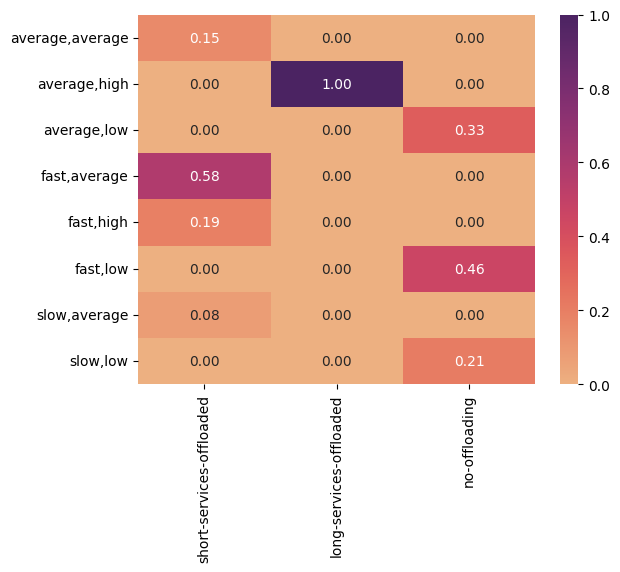

,short-services-offloaded,long-services-offloaded,no-offloading
"average,average",0.153846,0.0,0.000000
"average,high",0.000000,1.0,0.000000
"average,low",0.000000,0.0,0.333333
"fast,average",0.576923,0.0,0.000000
"fast,high",0.192308,0.0,0.000000
"fast,low",0.000000,0.0,0.458333
"slow,average",0.076923,0.0,0.000000
"slow,low",0.000000,0.0,0.208333


In [22]:
# def compute_robustness_matrix(my_space):
#     main_dict = dict()
#     for exp in tqdm(my_space.get_configurations()):
#         print(exp)
#         main_dict[str(exp)] = dict()
#         for qa in my_space.available_tradeoffs_.keys():
#             main_dict[str(exp)][qa], _ = my_space.compute_robustness(exp, qa)
#     df = pd.DataFrame.from_dict(main_dict, orient='columns').sort_index()
#     return df

print("Computing robustness for all configurations (whole space)...")
df = my_space.compute_robustness_matrix()
# df.to_csv('./gateway_offloading_robustness_matrix.csv')

sns.heatmap(df, annot=True, fmt=".2f", cmap='flare')
plt.show()
df

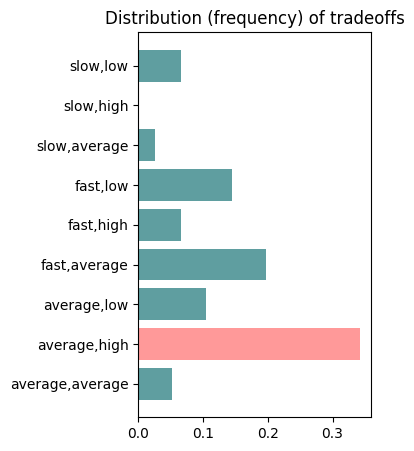

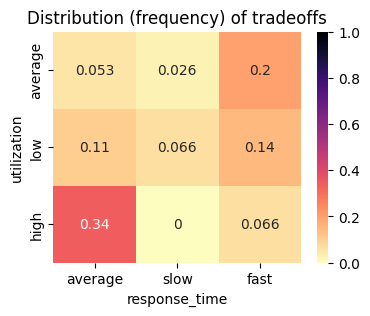

In [23]:
show_tradeoff_distribution(my_space, size=(3,5))
show_tradeoff_distribution(my_space, size=(4,3), in2D=True)

In [24]:
label_values_df = my_space.describe_labels(n_bins=3)
label_values_df

,objective,min,max,label
0,response_time,171.579852,241.713123,fast
1,response_time,241.713123,311.846394,average
2,response_time,311.846394,381.979665,slow
3,utilization,-0.100000,0.299998,low
4,utilization,0.299998,0.699997,average
5,utilization,0.699997,1.099995,high


  Computing robustness for all configurations (train set)...
Counter({'average,high': 14, 'fast,average': 9, 'fast,low': 6, 'average,low': 5, 'fast,high': 4, 'slow,low': 3, 'average,average': 3, 'slow,average': 1})


100%|██████████| 3/3 [00:00<00:00, 29.71it/s]


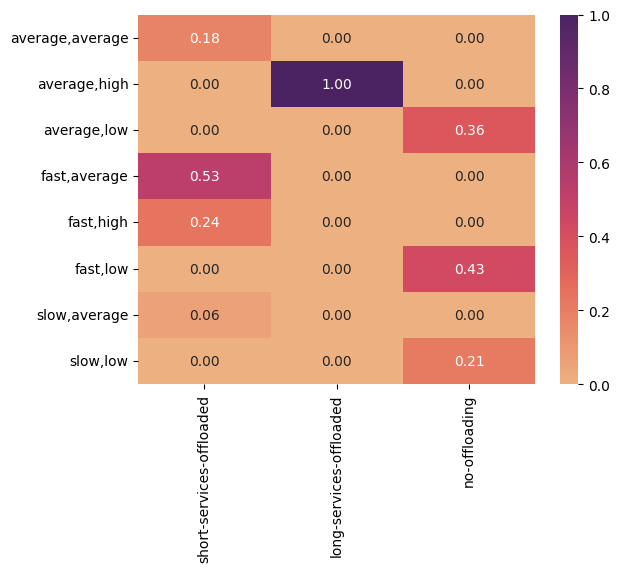

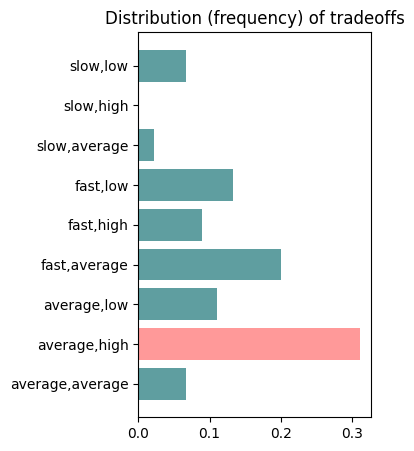

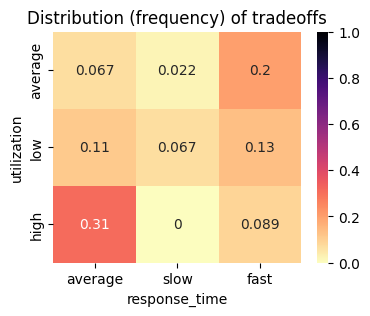

,short-services-offloaded,long-services-offloaded,no-offloading
"average,average",0.176471,0.0,0.000000
"average,high",0.000000,1.0,0.000000
"average,low",0.000000,0.0,0.357143
"fast,average",0.529412,0.0,0.000000
"fast,high",0.235294,0.0,0.000000
"fast,low",0.000000,0.0,0.428571
"slow,average",0.058824,0.0,0.000000
"slow,low",0.000000,0.0,0.214286


In [30]:
# Work first with the train set

# my_space.import_dataset(X_test, y_test)
my_space.import_dataset(X_train, y_train)
_ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)

print("  Computing robustness for all configurations (train set)...")
print(my_space.available_tradeoffs_)

df = my_space.compute_robustness_matrix()
sns.heatmap(df, annot=True, fmt=".2f", cmap='flare')

show_tradeoff_distribution(my_space, size=(3,5))
show_tradeoff_distribution(my_space, size=(4,3), in2D=True)

df

  Computing robustness for all configurations (test set)...
Counter({'average,high': 12, 'fast,average': 6, 'fast,low': 5, 'average,low': 3, 'slow,low': 2, 'average,average': 1, 'slow,average': 1, 'fast,high': 1})


100%|██████████| 3/3 [00:00<00:00, 16.15it/s]


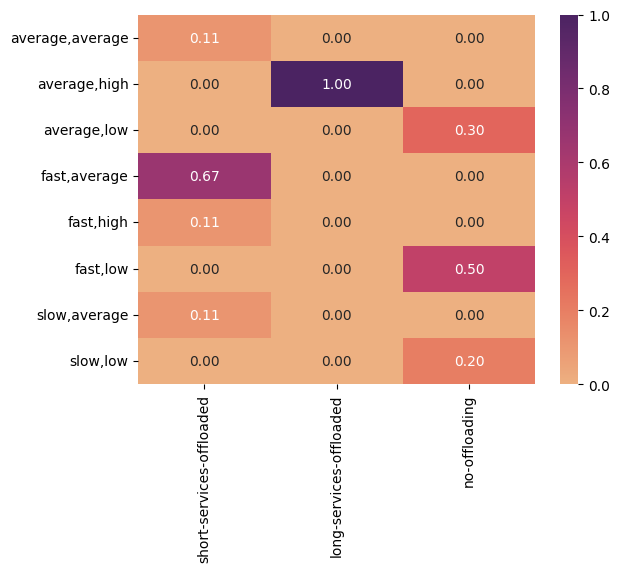

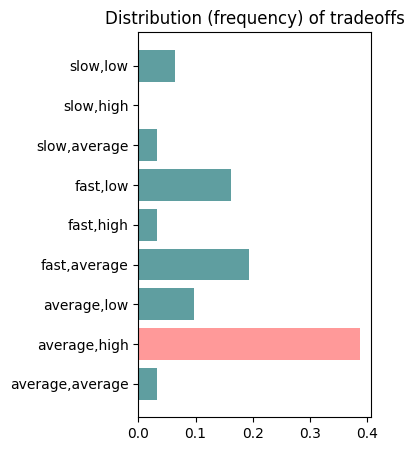

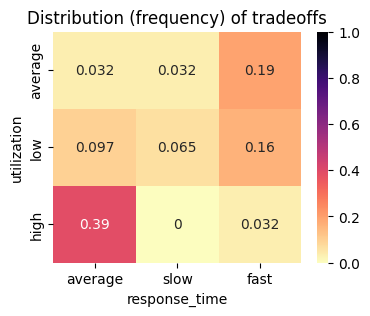

,short-services-offloaded,long-services-offloaded,no-offloading
"average,average",0.111111,0.0,0.0
"average,high",0.000000,1.0,0.0
"average,low",0.000000,0.0,0.3
"fast,average",0.666667,0.0,0.0
"fast,high",0.111111,0.0,0.0
"fast,low",0.000000,0.0,0.5
"slow,average",0.111111,0.0,0.0
"slow,low",0.000000,0.0,0.2


In [31]:
my_space.import_dataset(X_test, y_test)
# my_space.import_dataset(X_train, y_train)
_ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)

print("  Computing robustness for all configurations (test set)...")
print(my_space.available_tradeoffs_)

df = my_space.compute_robustness_matrix()
sns.heatmap(df, annot=True, fmt=".2f", cmap='flare')

show_tradeoff_distribution(my_space, size=(3,5))
show_tradeoff_distribution(my_space, size=(4,3), in2D=True)

df

In [26]:
# Run PRIM for each tradeoff using the train set, and then evaluate the robustness achieved on the test set
warnings.filterwarnings('ignore')
# my_space.import_dataset(X_train, y_train)

# kp = ['N_A', 'N_B', 'r_gw', 'r_A_s1', 'r_B_s2', 'r_B_s3']
kp = ['N_A', 'N_B', 'S_gw'] #, 'r_A_s1', 'r_B_s2', 'r_B_s3']
my_policies = my_space.get_configurations()
qa_labels = list(my_space.available_tradeoffs_.keys())
qa_labels.sort()
for qa_label in qa_labels:
    # Also loop over the different policies (configurations)?
    # for policy in my_policies:
        policy = None
        my_space.import_dataset(X_train, y_train)
        _ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)
        n = my_space.available_tradeoffs_[qa_label]
        
        if n > 0:
            print()
            print("Checking (with PRIM) ----")
            property_to_check = my_space.get_property_box(qa_label)
            print("  Property: ", qa_label, property_to_check)
            print("  Policy: ", policy)

            try:
                box1, prange, prim_model = my_space.run_prim(property_to_check, policy=policy,
                                                         threshold=0.8, method='rhodium', # 'emaw' 'rhodium'
                                                         key_parameters=kp, verbose=False)
                # print(box1)
                print("  New ranges:",  prange)
            except Exception:
                print("EXCEPTION triggered!") 
                pass

            my_space.import_dataset(X_test, y_test)
            my_space.adjust_parameters(prange)
            _ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)
            print("  Experiments:", my_space.experiments_df_.shape)
            print(my_space.compute_robustness(policy, qa_label))

            print("  Computing robustness for all configurations (test set) ...")
            df = my_space.compute_robustness_matrix()
            print(df)
            # plt.show()

my_space.import_dataset(X_train, y_train)
_ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)



Checking (with PRIM) ----
  Property:  average,average {'response_time': (242.3, 313.70000000000005), 'utilization': (0.30000000000000004, 0.7000000000000002)}
  Policy:  None
  New ranges: {'N_A': {'min': 0.0, 'max': 23.0}, 'S_gw': {'min': 2.5000000000000004, 'max': 7.5}}
  Experiments: (8, 11)
(0.0, 'average,average')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 37.73it/s]


                 short-services-offloaded
average,average                     0.125
fast,average                        0.750
fast,high                           0.125

Checking (with PRIM) ----
  Property:  average,high {'response_time': (242.3, 313.70000000000005), 'utilization': (0.7000000000000002, 1.1)}
  Policy:  None
  New ranges: {'S_gw': {'min': 7.5, 'max': 10.0}}
  Experiments: (12, 11)
(0.0, 'average,high')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 106.69it/s]


              long-services-offloaded
average,high                      1.0

Checking (with PRIM) ----
  Property:  average,low {'response_time': (242.3, 313.70000000000005), 'utilization': (-0.1, 0.30000000000000004)}
  Policy:  None
  New ranges: {'N_A': {'min': 4.0, 'max': 20.0}, 'S_gw': {'min': 1e-15, 'max': 2.5000000000000004}}
  Experiments: (6, 11)
(0.0, 'average,low')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 68.72it/s]


             no-offloading
average,low       0.166667
fast,low          0.833333

Checking (with PRIM) ----
  Property:  fast,average {'response_time': (170.9, 242.3), 'utilization': (0.30000000000000004, 0.7000000000000002)}
  Policy:  None
  New ranges: {'N_A': {'min': 1.0, 'max': 19.0}, 'S_gw': {'min': 2.5000000000000004, 'max': 7.5}}
  Experiments: (6, 11)
(0.0, 'fast,average')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 74.07it/s]


              short-services-offloaded
fast,average                  0.833333
fast,high                     0.166667

Checking (with PRIM) ----
  Property:  fast,high {'response_time': (170.9, 242.3), 'utilization': (0.7000000000000002, 1.1)}
  Policy:  None
  New ranges: {'N_A': {'min': 8.0, 'max': 12.0}, 'S_gw': {'min': 2.5000000000000004, 'max': 7.5}}
  Experiments: (1, 11)
(0.0, 'fast,high')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 148.55it/s]


           short-services-offloaded
fast,high                       1.0

Checking (with PRIM) ----
  Property:  fast,low {'response_time': (170.9, 242.3), 'utilization': (-0.1, 0.30000000000000004)}
  Policy:  None
  New ranges: {'N_A': {'min': 7.0, 'max': 16.0}, 'S_gw': {'min': 1e-15, 'max': 2.5000000000000004}}
  Experiments: (4, 11)
(0.0, 'fast,low')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 167.36it/s]


          no-offloading
fast,low            1.0

Checking (with PRIM) ----
  Property:  slow,average {'response_time': (313.70000000000005, 385.1), 'utilization': (0.30000000000000004, 0.7000000000000002)}
  Policy:  None
  New ranges: {'N_A': {'min': 21.0, 'max': 24.0}, 'S_gw': {'min': 2.5000000000000004, 'max': 7.5}}
  Experiments: (1, 11)
(0.0, 'slow,average')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 240.78it/s]


                 short-services-offloaded
average,average                       1.0

Checking (with PRIM) ----
  Property:  slow,low {'response_time': (313.70000000000005, 385.1), 'utilization': (-0.1, 0.30000000000000004)}
  Policy:  None
  New ranges: {'S_gw': {'min': 1e-15, 'max': 2.5000000000000004}}
  Experiments: (10, 11)
(0.0, 'slow,low')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 56.89it/s]

             no-offloading
average,low            0.3
fast,low               0.5
slow,low               0.2


In [27]:
policy = None
my_space.import_dataset(X_train, y_train)
_ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)
# n = my_space.available_tradeoffs_[qa_label]

# kp = ['N_A', 'N_B', 'r_gw', 'r_A_s1', 'r_B_s2', 'r_B_s3']
kp = ['N_A', 'N_B', 'S_gw'] #, 's_A_s1', 's_B_s2', 's_B_s3']        
print("Checking (with CART) ---- all properties")
print("  Policy: ", policy)


triple_rules, ranges, cart_model = my_space.run_cart(key_parameters=kp, prune_tree=True)
clf = cart_model.clf
print("nodes:", clf.tree_.node_count, "leaves:", clf.get_n_leaves())
print("  New ranges:")
for r in ranges.keys():
    print("\t", r, ranges[r])
print("Rules:")
for t in triple_rules:
    print(t)

print()
print("Testing ---- ")
qa_labels = list(my_space.available_tradeoffs_.keys())
qa_labels.sort()
for qa_label in ranges: # qa_labels:
    print()
    property_to_check = my_space.get_property_box(qa_label)
    prange = ranges[qa_label]
    print("  Property: ", qa_label, property_to_check)
    print("  Range:",  prange)
    
    my_space.import_dataset(X_test, y_test)
    my_space.adjust_parameters(prange)
    n = my_space.available_tradeoffs_[qa_label]
    if n > 0:
        _ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)
        print("  Experiments:", my_space.experiments_df_.shape)
        if my_space.experiments_df_.shape[0] > 0:
            print(my_space.compute_robustness(policy, qa_label))

        print("  Computing robustness for all configurations (test set) ...")
        df = my_space.compute_robustness_matrix()
        print(df)
        # plt.show()
    else:
        print("  No experiments in this range")

my_space.import_dataset(X_train, y_train)
_ = my_space.discretize_outcomes(mins_maxs=MIN_MAX_RANGES)

Checking (with CART) ---- all properties
  Policy:  None
(45, 3) Index(['N_A', 'N_B', 'S_gw'], dtype='object')
Running CART ... 0.044444444444444446
nodes: 19 leaves: 11
  New ranges:
	 average,high {'S_gw': {'min': 7.500000001, 'max': inf}}
	 fast,low {'S_gw': {'min': 0, 'max': 2.5}, 'N_B': {'min': 0, 'max': 19.5}, 'N_A': {'min': 0, 'max': 16.5}}
	 fast,average {'S_gw': {'min': 2.500000001, 'max': 7.5}, 'N_B': {'min': 18.000000001, 'max': inf}, 'N_A': {'min': 0, 'max': 20.0}}
	 fast,high {'S_gw': {'min': 2.500000001, 'max': 7.5}, 'N_B': {'min': 12.500000001, 'max': 18.0}, 'N_A': {'min': 0, 'max': 20.0}}
	 average,average {'S_gw': {'min': 2.500000001, 'max': 7.5}, 'N_A': {'min': 20.000000001, 'max': inf}}
	 average,low {'S_gw': {'min': 0, 'max': 2.5}, 'N_A': {'min': 16.500000001, 'max': 19.5}}
	 slow,low {'S_gw': {'min': 0, 'max': 2.5}, 'N_B': {'min': 19.500000001, 'max': inf}, 'N_A': {'min': 0, 'max': 16.5}}
Rules:
[('>', 'S_gw', 7.5), ('class', 'average,high', 1.0)]
[('<=', 'S_gw', 7

100%|██████████| 1/1 [00:00<00:00, 127.72it/s]

          no-offloading
fast,low            1.0

  Property:  fast,average {'response_time': (170.9, 242.3), 'utilization': (0.30000000000000004, 0.7000000000000002)}
  Range: {'S_gw': {'min': 2.500000001, 'max': 7.5}, 'N_B': {'min': 18.000000001, 'max': inf}, 'N_A': {'min': 0, 'max': 20.0}}


  Experiments: (2, 11)
(0.0, 'fast,average')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 103.40it/s]


              short-services-offloaded
fast,average                       1.0

  Property:  fast,high {'response_time': (170.9, 242.3), 'utilization': (0.7000000000000002, 1.1)}
  Range: {'S_gw': {'min': 2.500000001, 'max': 7.5}, 'N_B': {'min': 12.500000001, 'max': 18.0}, 'N_A': {'min': 0, 'max': 20.0}}
  Experiments: (2, 11)
(0.0, 'fast,high')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 72.22it/s]


              short-services-offloaded
fast,average                       0.5
fast,high                          0.5

  Property:  average,average {'response_time': (242.3, 313.70000000000005), 'utilization': (0.30000000000000004, 0.7000000000000002)}
  Range: {'S_gw': {'min': 2.500000001, 'max': 7.5}, 'N_A': {'min': 20.000000001, 'max': inf}}
  Experiments: (2, 11)
(0.0, 'average,average')
  Computing robustness for all configurations (test set) ...


100%|██████████| 1/1 [00:00<00:00, 64.72it/s]


                 short-services-offloaded
average,average                       0.5
slow,average                          0.5

  Property:  average,low {'response_time': (242.3, 313.70000000000005), 'utilization': (-0.1, 0.30000000000000004)}
  Range: {'S_gw': {'min': 0, 'max': 2.5}, 'N_A': {'min': 16.500000001, 'max': 19.5}}
  Experiments: (0, 11)
  Computing robustness for all configurations (test set) ...


0it [00:00, ?it/s]

Empty DataFrame
Columns: []
Index: []

  Property:  slow,low {'response_time': (313.70000000000005, 385.1), 'utilization': (-0.1, 0.30000000000000004)}
  Range: {'S_gw': {'min': 0, 'max': 2.5}, 'N_B': {'min': 19.500000001, 'max': inf}, 'N_A': {'min': 0, 'max': 16.5}}
  No experiments in this range
